<html>
<body>

<h1 align="center">MSIN0097: Predictive Analytics</h1>
<h1 align="center">Invidiual Coursework</h1>
<h1 align="center"> Prediction on Online Purchasing Intention</h1>
<br>
<h3 align="center">Word Count: 1494</h3>
<h3 align="center">March 2022</h3>
<br>
<h3> <a href="https://github.com/uceix42/pa-individual/blob/main/PA-March-2022.ipynb">Repository</a>
<br> </h3>
<h3 align='left'> Table of Contents </h3> 
</body>
</html>

* [Notebook Setup](#Notebook-Setup)
* [1. Introduction](#1.-Introduction)
* [2. Get the Data](#2.-Get-the-Data)
* [3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
* [4. Preprocessing](#4.-Preprocessing)
* [5. Model Training](#5.-Model-Training)
* [6. Model Evaluation](#6.-Model-Evaluation)
* [7. Conclusion](#7.-Conclusion)
* [Reference](#Reference) 
* [Appendix](#Appendix)



In [44]:
# Code source: https://gist.github.com/agounaris/5da16c233ce480e75ab95980831f459e

import io
from IPython.nbformat import current

with io.open('./PA-March-2022.ipynb', 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
        
print("Word Count:",word_count)

Word Count: 1494


### Notebook Setup
Below are libraries will be used in this notebook, and user-defined plot functions for visualization.

In [100]:
# common imports
import pandas as pd
import numpy as np

# figures
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ML task
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# fine tune
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# to deal with skewed data distribution
try:
    from imblearn.combine import SMOTETomek
except ModuleNotFoundError:
    !pip install imblearn
    from imblearn.combine import SMOTETomek
    
# evaluation
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay


# random seed
np.random.seed(42)

import warnings

In [102]:
def classifiers_input(classifiers_dict, trainingX, trainingy, validationX, validationy) -> dict: 
    for model in classifiers_dict.keys():
        #fit
        classifiers_dict[model]["fit"].fit(trainingX, trainingy)
        #predict
        classifiers_dict[model]["pred"] = classifiers_dict[model]["fit"].predict(validationX)
        classifiers_dict[model]["proba_val"] = classifiers_dict[model]["fit"].predict_proba(validationX)
        classifiers_dict[model]["proba_train"] = classifiers_dict[model]["fit"].predict_proba(trainingX)
        # evaluation
        classifiers_dict[model]["acc_train"] = classifiers_dict[model]['fit'].score(trainingX, trainingy)
        classifiers_dict[model]["acc_val"] = classifiers_dict[model]['fit'].score(validationX, validationy)
        classifiers_dict[model]["conf"] = confusion_matrix(validationy, classifiers_dict[model]["pred"])
    return


def evaluation_comparion(classifiers,testingy):
    """
    To output a dataframe includes several evaluation metrces for model comparison
    """
    # create measurement dictonary
    measures = {"F1": f1_score, "Precision": precision_score, "Recall": recall_score, "Accuracy": accuracy_score}
    # create performance result df
    results = pd.DataFrame(columns=measures.keys())
    
    for model in classifiers.keys():
        results.loc[model] = [round(measures[measure](testingy, classifiers[model]["pred"]),4) for measure in measures.keys()]
    results = results.sort_values(by=['F1'], ascending=False)
    
    return results

def plot_evaluation_comparison(result_df):
    """
    Visualize metreces dataframe 
    """
    ax = plt.subplot(111)
    ind = np.arange(result_df.shape[0])
    width = 0.2
    l = ax.plot(ind, result_df, "-o")
    plt.legend(iter(l), result_df.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(result_df.index)
    plt.show()

def plot_confusion_matrix(nrows, ncols, classifiers, validationy, validationX):
    """
    Visualize nested confusion matrix
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
    
    for cls, ax in zip(classifiers, axes.ravel()):
#         conf = classifiers_dict[model]["conf_ma"]
        ConfusionMatrixDisplay.from_predictions(y_true=validationy,
                                                y_pred=classifiers[cls]['fit'].predict(validationX),
                                                ax=ax, cmap='Blues')
        ax.title.set_text(cls)
        
    plt.tight_layout()  
    plt.show()


#  1. Introduction

##### Business Objective

In physical retailing, salespeople could provide a customized recommendation to shoppers based on their experience and feedback. That is of influence on the purchase conversion rate and sales. Similarly, it is beneficial for online retailers to mimic such a salesperson to increase purchase conversion rate. To achieve that goal, it would be helpful to analyze online shoppers' behaviours.

This report aims to conduct such an analysis by predicting online shoppers' purchasing behaviours. We use online shoppers' browsing behaviours and their features from an online retailer to fit and train different models, the output will be an optimal model which predicts each shopper's purchase intention. The output model could be deployed into online marketing and recommendation system for online retailers to increase purchase conversion rate or detact target customers online in the early statge.


##### Machine Learning Task

The online shopper dataset of the online retailer is from previous similar research (Sakar et al., 2018). There is originally 12,330 sessions and 17 features in total. Within all, there are ten numerical features and seven categorical features. The dependent variable 'Revenue' is a binary variable, where 'True' indicates an online shopper made a transaction on that session while 'False' is not. (More details in Appendix)

Given the business objective and the dataset, it is best to perform a supervised machine learning task with 'Revenue' to be the label. Specifically, the task in this report is a binary classification task as its dependent variable is binary.



# 2. Get the Data

In [4]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


# 3. Exploratory Data Analysis

##### Visualization for numerical features


In [7]:
cat_cols = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend','Month']
num_cols = [col for col in df.columns if col not in cat_cols and col != 'Revenue']

# change datetypes for categories
for col in cat_cols:
    df[str(col)] = df[str(col)].astype('category')

# define features
features = cat_cols + num_cols

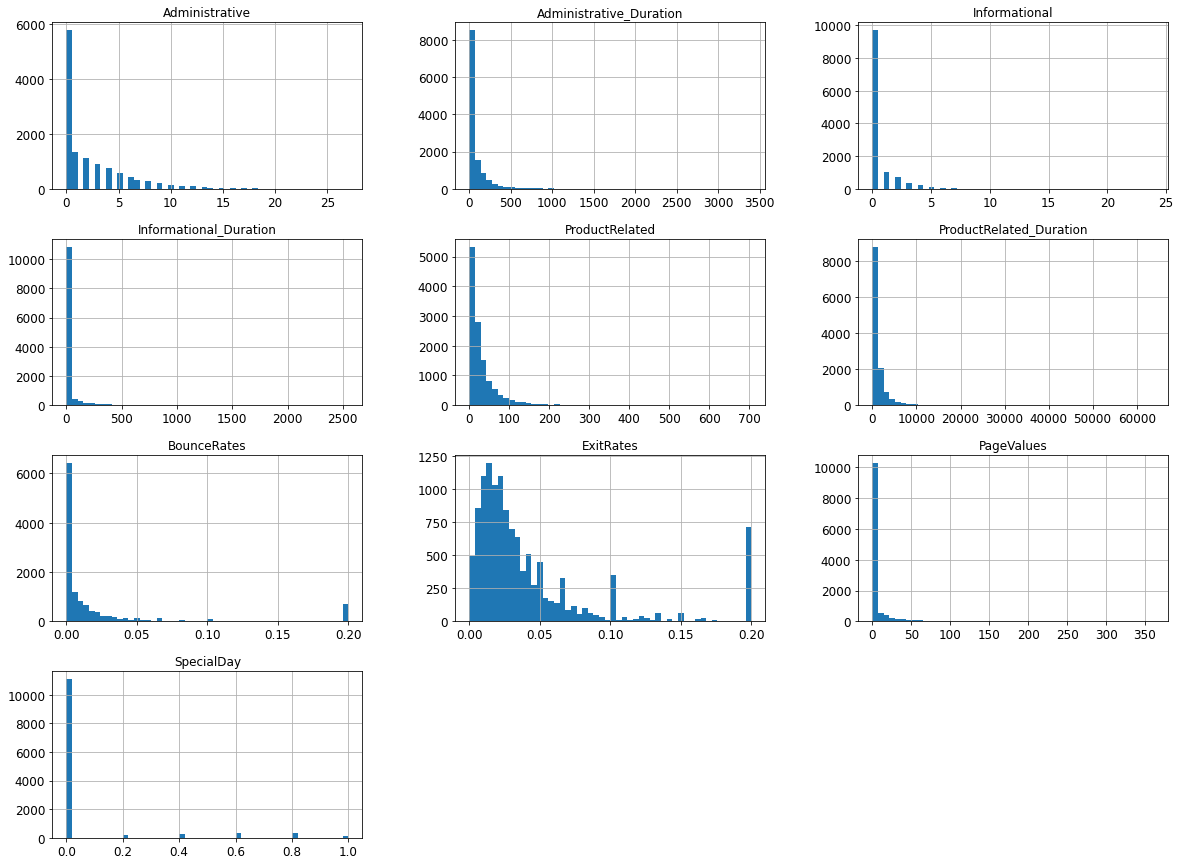

In [8]:
# visualize numeric features
df[num_cols].hist(bins=50, figsize=(20,15))
plt.show()

Text(0, 0.5, 'Revenue')

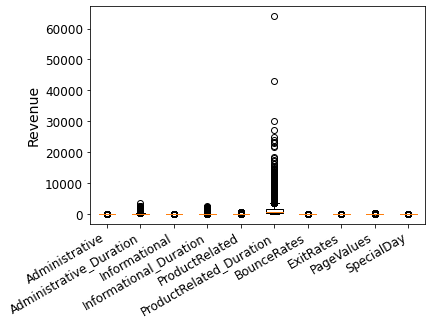

In [9]:
plt.boxplot(df[num_cols])
plt.xticks(np.arange(1, df[num_cols].shape[1] + 1), df[num_cols].columns, rotation=30, ha="right")
plt.ylabel("Revenue")

From the boxplot for numeric features, we see that *ProductRleated_Duration* variable has several outliers. In addition to it, each variables are in different ranges. We need to do data standardization for later processing.

##### Visualization for categorical features

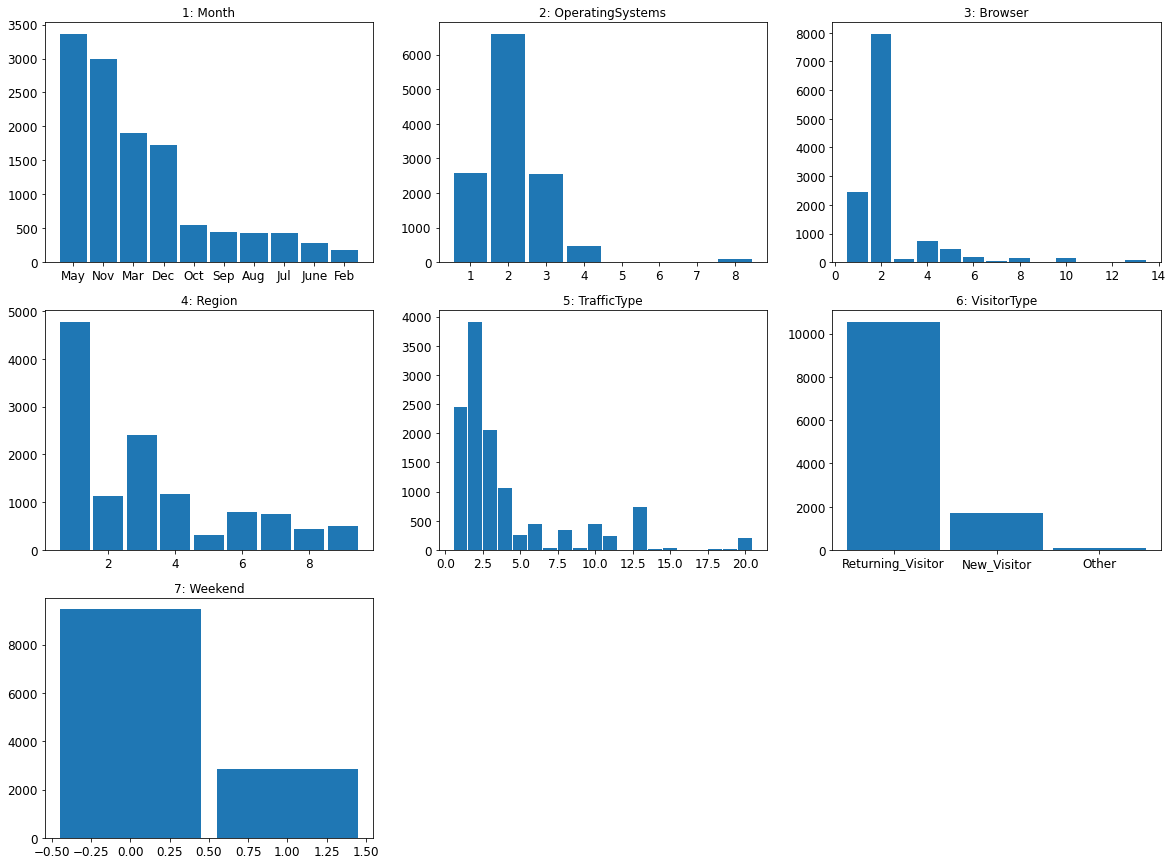

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(axes.ravel()):
    if i > 6:
        ax.set_visible(False)
        continue
    height = df[cat_cols].iloc[:,i-1].value_counts().sort_values(ascending=False)
    x = height.index
    ax.bar(x, height, width=0.9)
    ax.set_title("{}: {}".format(i+1, cat_cols[i-1]))


##### Visualization for correlation

In [11]:
corr_matrix = df.corr()
corr_matrix['Revenue'].sort_values(ascending=False)

Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64

<AxesSubplot:>

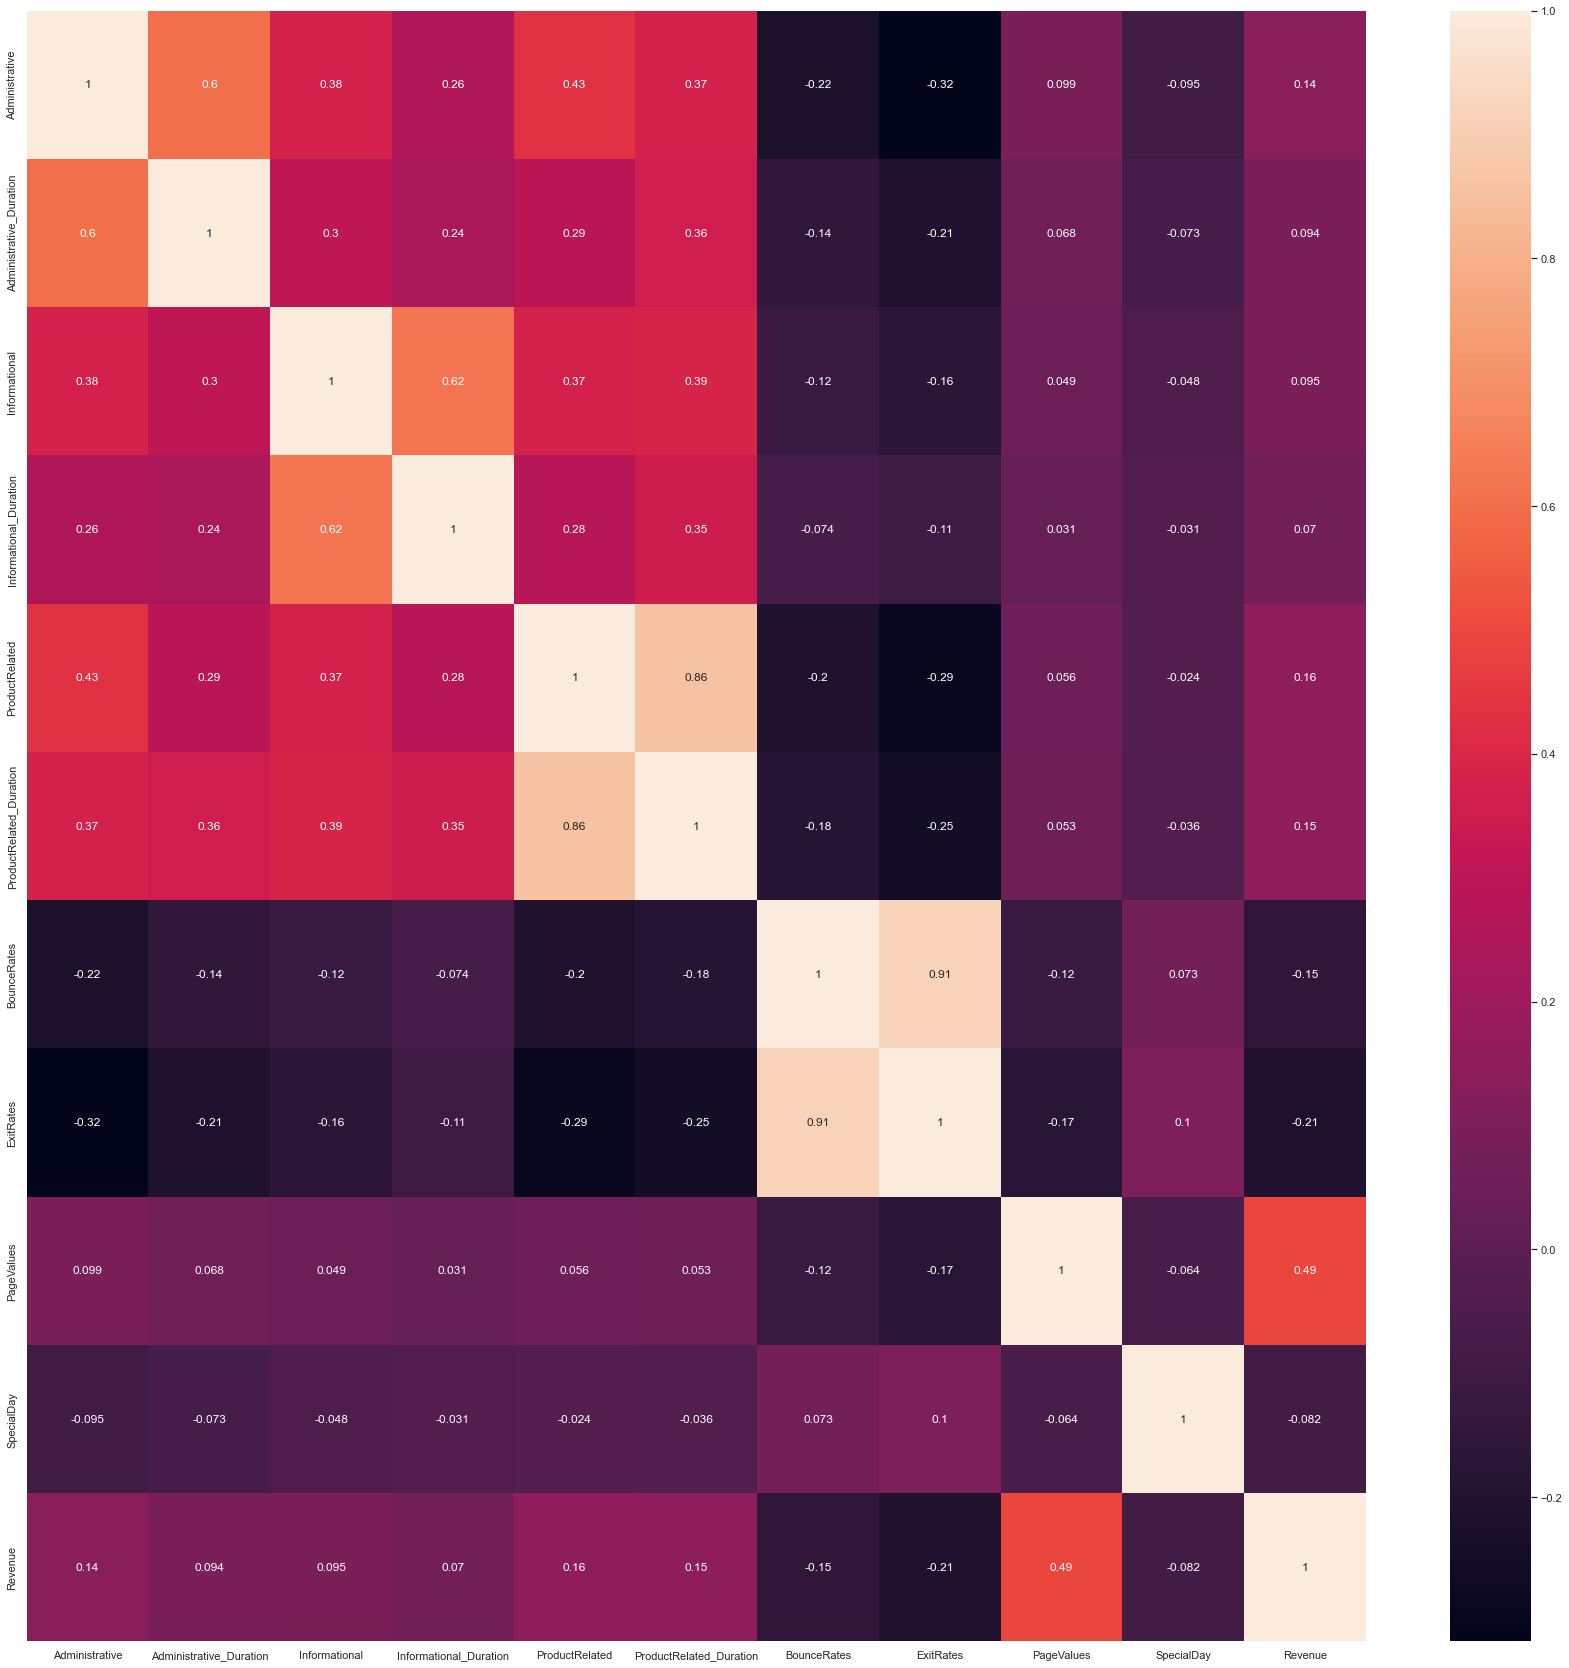

In [12]:
sns.set(rc={'figure.figsize':(30, 30)})
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix), annot=True)

# 4. Preprocessing


In [13]:
# to see if there are missing values
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

There is no missing values, thus do not need to impute for missing values.
##### Categorical features: OneHotEncoding

In [14]:
# print all categories for each categorical variable
categories = [df[col].unique() for col in df[cat_cols]]
categories 

[[1, 2, 4, 3, 7, 6, 8, 5]
 Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8],
 [1, 2, 3, 4, 5, ..., 8, 9, 12, 13, 11]
 Length: 13
 Categories (13, int64): [1, 2, 3, 4, ..., 10, 11, 12, 13],
 [1, 9, 2, 3, 4, 5, 6, 7, 8]
 Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 9],
 [1, 2, 3, 4, 5, ..., 18, 19, 16, 17, 20]
 Length: 20
 Categories (20, int64): [1, 2, 3, 4, ..., 17, 18, 19, 20],
 ['Returning_Visitor', 'New_Visitor', 'Other']
 Categories (3, object): ['New_Visitor', 'Other', 'Returning_Visitor'],
 [False, True]
 Categories (2, object): [False, True],
 ['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep', 'Dec']
 Categories (10, object): ['Aug', 'Dec', 'Feb', 'Jul', ..., 'May', 'Nov', 'Oct', 'Sep']]

In [15]:
# an illustration using sklearn OneHotEncoder to encode categorical features here
cat_encoder = OneHotEncoder(sparse=False, drop='first')
cat_ohe = cat_encoder.fit_transform(df[cat_cols])
print(cat_ohe.shape)

# check if the categories are correct
cat_encoder.categories_

(12330, 58)


[array([1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 array(['New_Visitor', 'Other', 'Returning_Visitor'], dtype=object),
 array([False, True], dtype=object),
 array(['Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov', 'Oct',
        'Sep'], dtype=object)]

In [16]:
# perform one hot encoding using dataframe function
for col in cat_cols:
    df[col] = df[col].astype('category')
dummies = pd.get_dummies(df[cat_cols], drop_first=True)

In [17]:
ohe_df = pd.DataFrame(cat_ohe, columns=dummies.columns)

##### Numerical features

In the scope of this report, SVM is one of the model candidates, the algorithm behind it is to minimize the decision vector w, thus it's better to feed standardized data into it. As a result, we will use StandardScaler here for numerical features.

In [18]:
num_scaler = StandardScaler()
num_scaled = num_scaler.fit_transform(df[num_cols])

# check shape
print(num_scaled.shape)
print(df[num_cols].shape)


(12330, 10)
(12330, 10)


In [19]:
num_df = pd.DataFrame(num_scaled, columns=num_cols)

In [20]:
# plt.boxplot(num_df)
# plt.xticks(np.arange(1, num_df.shape[1] + 1), num_df.columns, rotation=30, ha="right", fig_size=(10,8))
# plt.ylabel("Revenue")
# figsize=(10,8)

##### Prepared dataframe

Below presents two methods to come up with the prepared dataset for model training.

In [21]:
# method1: using pipeline to process data preprocessing phase and convert it into array
preprocess_pip = ColumnTransformer([
    ("num", num_scaler, num_cols),
    ("cat", cat_encoder, cat_cols),])

arra = preprocess_pip.fit_transform(df)
arra.shape

(12330, 68)

In [22]:
arra

array([[-0.69699296, -0.4571914 , -0.3964779 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.50722805, -0.03291592, -0.3964779 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  1.        ,
         0.        ,  0.        ]])

In [23]:
# method2: 
dfEcom = pd.concat([num_df, ohe_df, df.Revenue], axis=1)
dfEcom.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# 5. Model Training



The very first step for model training is to split data into three datasets for different purposes. In this report, data is first split into a training set and a testing set with a proportion of 80% and 20% respectively, where the former is used to train the classifiers while the latter is used to provide an unbiased evaluation of the trained models. Next, 25% of the training set is divided into a validation set with the aim to provide an unbiased evaluation of fitted models during the hyperparameters' fine-tuning process.


In [24]:
X = dfEcom.loc[:, dfEcom.columns != 'Revenue']
ydf = pd.get_dummies(df.Revenue,drop_first=True, prefix='Revenue')
y = ydf['Revenue_True']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# check each shape per dataset
print(X_train.shape, X_val.shape, X_test.shape)
X_test.head()

(7398, 68) (2466, 68) (2466, 68)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Weekend_True,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
8916,0.206173,0.348932,-0.396478,-0.244931,0.365801,-0.074462,-0.368012,-0.617956,-0.317178,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
772,1.109339,2.017134,1.178195,1.428680,1.152783,0.684125,-0.412355,-0.785204,-0.204820,-0.308821,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12250,-0.395938,-0.224547,-0.396478,-0.244931,2.119647,1.627964,-0.443497,-0.622497,-0.131313,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7793,-0.094882,0.340447,-0.396478,-0.244931,-0.488636,-0.307317,-0.285813,-0.343329,1.657882,-0.308821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6601,4.722002,2.983061,4.327541,4.968806,3.064025,1.961574,-0.320907,-0.607996,0.229506,-0.308821,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Fitting

In the scope of this report, the machine learning task is to do binary classification. There are several algorithms designed specifically for binary classification, and are included in this report:

* Logistic Regression

* k-Nearest Neighbors

* Decision Tree

* Support Vector Machine

Apart from above mentioned models, ensemble algorithms Random Forest are also included for comparison.

In [25]:
# create classifier dictionary
classifiers = {
    "KN": {"fit": KNeighborsClassifier()},
    "LR": {"fit": LogisticRegression(max_iter=250, random_state=42)},
    "DT": {"fit": DecisionTreeClassifier(random_state=42)},
    "RF": {"fit": RandomForestClassifier(random_state=42)},
    "SVM": {"fit": SVC(probability=True,random_state=42)}
    }

The performance of all five classifiers trained with the imbalanced training sets will be used as the baseline. Validation sets will be used to provide unbiased evaluation here.

Becasue the goals of this report are to predict online shoppers' purchase intention and to increase purchase conversion rate, it's of great importance to reduce the case of classifying a shopper with purchase intention (Positive) as a shopper without such (Negative). In other words, we are aiming to increase the True Positive Rate (Recall). 

In addition, to increase Recall, an online retailer might want to decrease online marketing costs by decreasing the chance of classifying a shopper without purchase intention (Negative) as a shopper with such (False Positive). Thus, the second evaluation criteria would be to increase the True Negative Rate (Precision).

In [48]:
#baseline
classifiers_input(classifiers, X_train, y_train, X_val, y_val)

In [49]:
for model in classifiers:
    (TN, FP, FN, TP) = classifiers[model]['conf'].ravel()
    acc_train = classifiers[model]['acc_train']
    acc_val = classifiers[model]['acc_val']
    if classifiers[model]['acc_train'] - classifiers[model]['acc_val'] > 0.05:
        print(f"{model} might has overfitting problem." )
        print(f"{model} accuracy difference between training and validating set is: {float(acc_train-acc_val): .4%}")
        print(f"{model} Recall = {float(TP/(TP+FN)):.4%}, FPR = {float(FP/(TN+FP)):.4%}\n")
    else:
        print(f"{model} Recall = {float(TP/(TP+FN)):.4%}, FPR = {float(FP/(TN+FP)):.4%}\n")


KN Recall = 40.6915%, FPR = 3.3493%

LR Recall = 38.8298%, FPR = 2.6316%

DT might has overfitting problem.
DT accuracy difference between training and validating set is:  15.1663%
DT Recall = 52.9255%, FPR = 9.4258%

RF might has overfitting problem.
RF accuracy difference between training and validating set is:  9.6377%
RF Recall = 51.8617%, FPR = 2.7273%

SVM Recall = 49.7340%, FPR = 3.2057%



In [51]:
evaluation_comparion(classifiers, y_val)

,F1,Precision,Recall,Accuracy
RF,0.6210,0.7738,0.5186,0.9035
SVM,0.5937,0.7362,0.4973,0.8962
DT,0.5155,0.5025,0.5293,0.8483
KN,0.5109,0.6861,0.4069,0.8812
LR,0.5061,0.7264,0.3883,0.8844


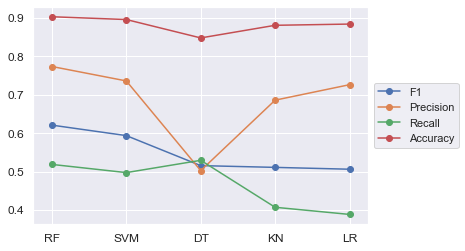

In [104]:
plot_evaluation_comparison(evaluation_comparion(classifiers, y_val))

### Resample
Due to the fact that the labels for the dataset are imbalanced, around 84.5% of the data are labelled as 'False', indicating no purchase is made in that session, while only 15.5% are labelled as 'True'. Considering the ultimate goal of this report is to predict wether there will be a purchase, we will mainly focus on the minority class which is 'True' in this case.

Generally, there are two methods to deal with the imbalanced class problem. One way is to modify the sample size, either by undersampling the majority class or by oversampling minority class. Another way is to implement cost-senstive learning to algorithms. 

According to previous research, cost-senstivie learning outperforms resampling techniques when dataset has more than 10,000 examples (Weiss, McCarthy, & Zabar, 2007). Considering the training set in this report is lower than 10,000, a combined resampling strategy will be implemented.

                          Count  Percentage
Negative (No purchase)    10422      0.8453
Positive (Made purchase)   1908      0.1547


<AxesSubplot:title={'center':'Count per class'}>

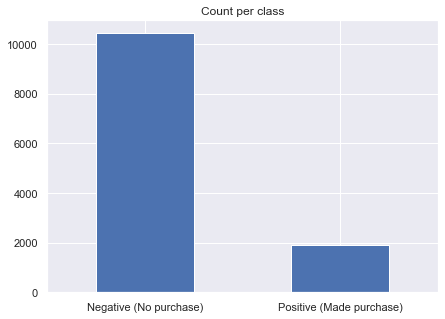

In [30]:
# Class label
label = pd.DataFrame(data = y.value_counts())
label.rename(columns={'Revenue_True': 'Count'}, inplace=True)
label['Percentage'] = round(label['Count']/label['Count'].sum(), 4)
label.index = ['Negative (No purchase)', 'Positive (Made purchase)']
print(label) # inbalanced class

# visualize
figsize = (7,5)
label.Count.plot(kind='bar', title='Count per class', figsize=figsize, rot=0)

##### SMOTETomek combined sampling

In [31]:
# combine oversampling and undersampling using SMOTE and Tomek
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
classifiers_input(classifiers, X_smt, y_smt, X_val, y_val)

In [32]:
y_train.shape, y_smt.shape

((7398,), (12550,))

In [33]:
classifiers['KN'].keys()

dict_keys(['fit', 'pred', 'proba_val', 'proba_train', 'acc_train', 'acc_val', 'conf'])

In [34]:
# report components of confusion matrix if the model is not overfitting
for model in classifiers:
    if classifiers[model]['acc_train'] - classifiers[model]['acc_val'] > 0.05:
        (TN, FP, FN, TP) = classifiers[model]['conf'].ravel()
        acc_train = classifiers[model]['acc_train']
        acc_val = classifiers[model]['acc_val']
        y_pred = classifiers[model]['pred']
        print(f"{model} might has a overfitting problem." )
        print(f"{model} accuracy difference between training and validating set is: {float(acc_train-acc_val): .4%}")
        print(f"{model} Recall = {float(TP/(TP+FN)):.4%}, precision = {precision_score(y_val, y_pred): .4%}\n")
    else:
        print(f"{model} Recall = {float(TP/(TP+FN)):.4%}, FPR = {precision_score(y_val, y_pred): .4%}\n")

KN might has a overfitting problem.
KN accuracy difference between training and validating set is:  15.8616%
KN Recall = 74.7340%, precision =  36.2113%

LR Recall = 74.7340%, FPR =  36.2113%

DT might has a overfitting problem.
DT accuracy difference between training and validating set is:  15.0041%
DT Recall = 59.0426%, precision =  50.6849%

RF might has a overfitting problem.
RF accuracy difference between training and validating set is:  11.2328%
RF Recall = 62.7660%, precision =  63.2708%

SVM Recall = 62.7660%, FPR =  63.2708%



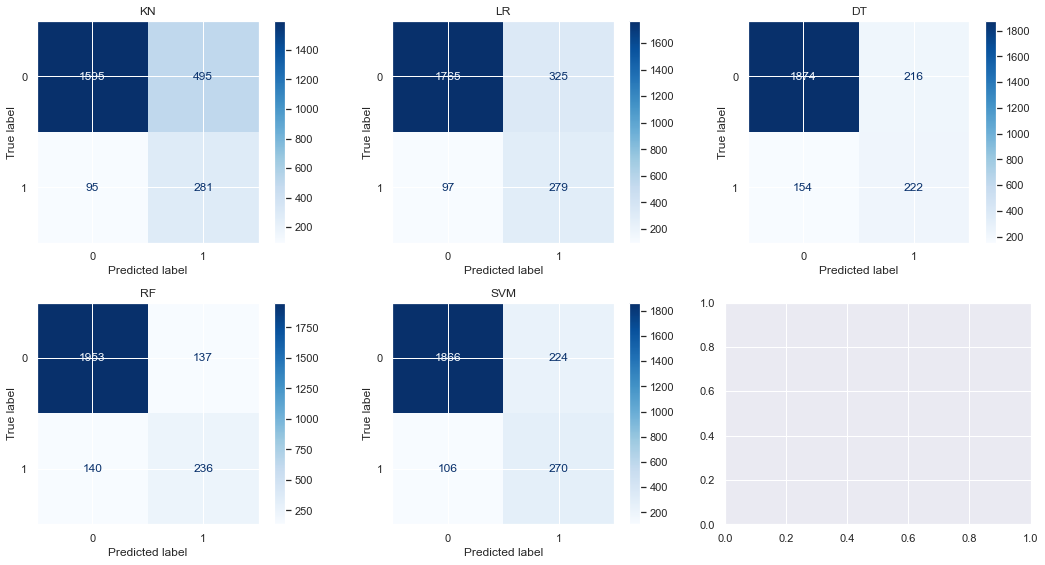

In [35]:
plot_confusion_matrix(2,3,classifiers, y_val, X_val)

In [36]:
eva = evaluation_comparion(classifiers, y_val)
eva

,F1,Precision,Recall,Accuracy
RF,0.6302,0.6327,0.6277,0.8877
SVM,0.6207,0.5466,0.7181,0.8662
LR,0.5694,0.4619,0.7420,0.8289
DT,0.5455,0.5068,0.5904,0.8500
KN,0.4878,0.3621,0.7473,0.7607


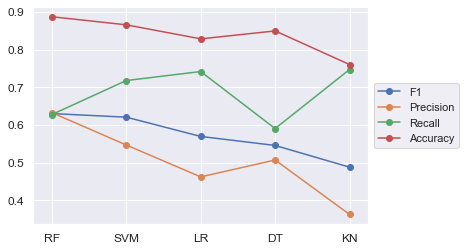

In [105]:
plot_evaluation_comparison(eva)

##### Hard Voting

Below is to denonstarte the performance of hard voting classifier on validation set. The recall score is relatively higher than the precision score, showing a less balanced performence between the two socres. As a result, we will not select hard voting classifier here for further investigation.

In [38]:
# create classifiers list
est_list = [(model, classifiers[model]["fit"]) for model in classifiers]

# fit into hard voting classifiers
voting_clf = VotingClassifier(estimators=est_list, voting='hard').fit(X_smt, y_smt)

In [39]:
y_pred=voting_clf.predict(X_val)

print(f"Recall = {recall_score(y_val, y_pred):.4f}")
print(f"Precision = {precision_score(y_val, y_pred): .4f}")

Recall = 0.7154
Precision =  0.5616


##### ROC Curve to compare all models

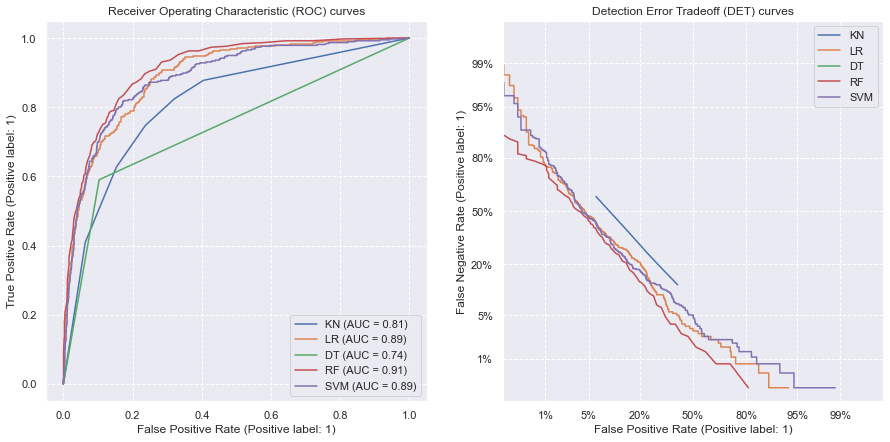

In [40]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(15, 7))

for name, clf in classifiers.items():
    # test on validation set
    RocCurveDisplay.from_estimator(clf['fit'], X_val, y_val, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf['fit'], X_val, y_val, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

According to the above, the RandomForestClassifer is shortlisted as the best model for further operation. Although the random forest classifier has a problem of overfitting the training set, its recall and precision outperform all other models except SVM. 

When comparing the SVM classifier and random forest classifier in the ROC plot, we observe that random forest lies above SVM.  In the meanwhile, in the detection error tradeoff plot, the random forest classifier lies below the SVM classifier. That is to say, the random forest model has the best ability to balance the tradeoff between precision and recall out of five models.

As a result, the RandomForestClassifer is shortlisted as the best for further model building.

# 6. Model Evaluation

In this section, we will fine-tune the optimal model RandomForestClassifier using both RandomizedSearchCV and GridsearchCV to fine-tune the model, and then perform error analysis based on the optimized model. 

Below, the parameter distribution is definedfor later use. It includes all the hyperparameters we want to perform fine-tuning and the value to be tested for them.


In [41]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, 6, None],
              "max_features":["auto", "sqrt", "log2"],
              "min_samples_leaf": range(2, 11, 2),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

##### RandomizedSearchCV

In [42]:
# run randomized search
rf_rdcv = RandomizedSearchCV(classifiers['RF']['fit'], param_distributions=param_dist,
                             n_iter=30, scoring='roc_auc', # specifiy scoring criteria
                             cv=10, # crosss validate for 10 sets
#                              verbose=4, # return logs
                             random_state=42, error_score='raise')
rf_rdcv.fit(X_smt, y_smt)

RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 6, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(2, 11, 2)},
                   random_state=42, scoring='roc_auc')

In [106]:
# print out best estimator result
rf_rdcv.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       random_state=42)

In [107]:
rf_rdcv.best_params_

{'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

In [108]:
# evaluate
y_pred = rf_rdcv.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

acc_train = rf_rdcv.score(X_smt,y_smt)
acc_test = rf_rdcv.score(X_test,y_test)

print(f"Recall = {recall:.4%}, Precision = {precision: .4%}")
print(f"Training accuracy {acc_train: .4%}, testing accuracy {acc_test: .4%}")
print(f"Accuracy difference {(acc_train - acc_test):.4%}")

Recall = 65.4501%, Precision =  67.2500%
Training accuracy  99.9992%, testing accuracy  91.8601%
Accuracy difference 8.1391%


Using RandomizedSearchCV returns a relatively balanced model between recall and precision score. The overfitting problem is slightly improved before fine-tuning. Next, we will see how GridSearchCV performs.


##### GridSearchCV

In [109]:
# run GridSearchCV
rf_gdcv = GridSearchCV(classifiers['RF']["fit"], 
                       param_grid=param_dist,
#                        verbose=4, # return logs
                       cv=10, 
                       scoring='roc_auc',
                       return_train_score=True
                       ).fit(X_train, y_train)

In [110]:
# print out best estimator
rf_gdcv.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=6,
                       random_state=42)

In [111]:
rf_gdcv.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 6}

In [112]:
# Evaluate
y_pred_gdcv = rf_gdcv.predict(X_test)

recall = recall_score(y_test, y_pred_gdcv)
precision = precision_score(y_test, y_pred_gdcv)

acc_train = rf_gdcv.score(X_smt,y_smt)
acc_test = rf_gdcv.score(X_test,y_test)

print(f"Recall = {recall:.4%}, Precision = {precision: .4%}")
print(f"Training accuracy {acc_train: .4%}, testing accuracy {acc_test: .4%}")
print(f"Accuracy difference {acc_train - acc_test: .4%}")

Recall = 51.3382%, Precision =  77.0073%
Training accuracy  98.4129%, testing accuracy  92.3980%
Accuracy difference  6.0149%


The overfitting problem is eased more after applying GridsearchCV. However, its performance on precision is largely greater than Recall, which is not in line with our main goal.

##### Comparison in confusion matrices and ROC-AUC curve

Below is the visualization of confusion matrices and ROC-DET curves using the testing dataset. 

The plots show that for RandomizedSearchCV returns a lower True Negative Rate (Precision) and a higher True Positive Rate (Recall), compared with GridSearchCV. This is consistant with what we saw above.

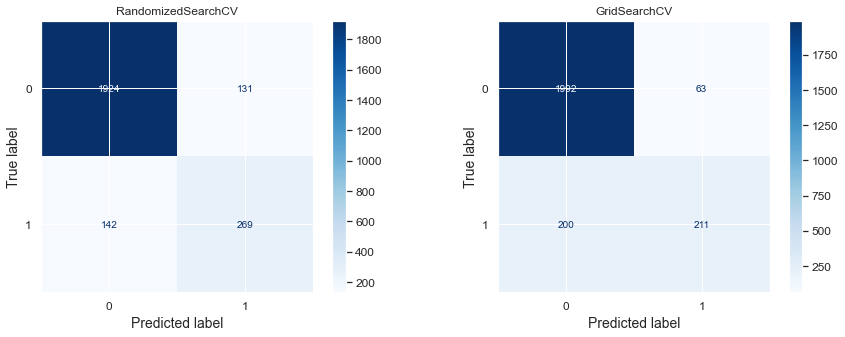

In [113]:
# dictionary for two fine-tuned model
final_clf = {'RandomizedSearchCV': rf_rdcv, 
             'GridSearchCV': rf_gdcv}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# plot confusion matrix
for cls, ax in zip(final_clf, axes.ravel()):
    ConfusionMatrixDisplay.from_predictions(y_test, final_clf[cls].predict(X_test), ax=ax, cmap='Blues')
    ax.title.set_text(cls)

To further illustrate the findings in confusion matrces cruves, below is the ROC and DET curves for two fine tunned classifiers. According to plots, we see that RandomizedSearchCV (blue line) is able to achieve a higher True Positive Rate with relatively lower False Positive Rate, compared with GridSearchCV.

As a result, the random forest classifier with RandomizedSearchCV would be the final optimal model. 

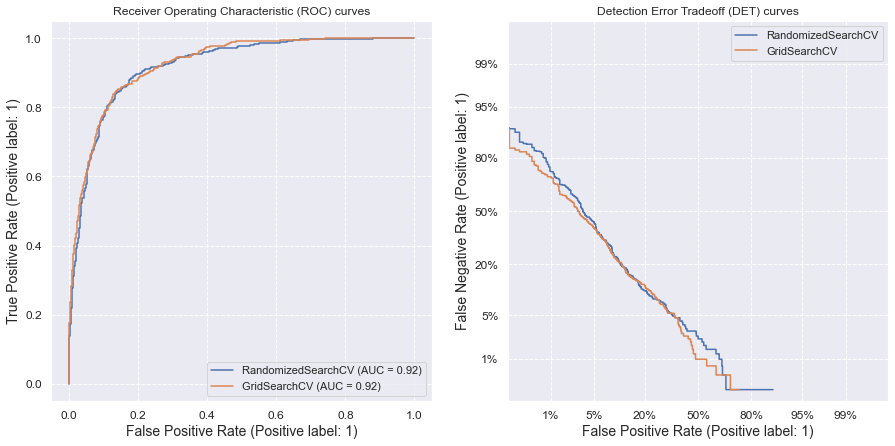

In [114]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(15, 7))

for name, clf in final_clf.items():
    # test on testing set
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

# 7. Conclusion

Recall that the main goal for this report is to find the optimal binary classification model which eases the trade-off between Recall and Precision, and to predict online shoppers' purchasing behaviours by deploying that model. 

With proper data cleaning and transformation, the report compared the prediction performance between five models: LogisticRegression, KNeighours, DecisionTree, SVM, and RandomForest. Additionally, hard voting classifiers are also included for reference. After model evaluation and hyperparameter tuning, this report concludes the random forest classifier with RandomizedSearchCV is the optimal model for predicting online purchasing intention.


##### Deployment

With a 0.92 AUC score, the model is able to better classify an online shopper's purchase intention. Online Retailers could use this model to achieve higher revenue with a more accurate targeting strategy and a higher purchase conversion rate.


###### Limitation

Although the concluded optimal model presents the best performance for both Recall and Precision, the model still exits an overfitting problem. One way to ease this problem is to apply PCA to reduce the dimensionalities of features, this could also reduce the dimensionality of features that are highly correlated with each other.

# Reference

Sakar, C., Polat, S., Katircioglu, M., & Kastro, Y. (2018, May 09). *Real-time prediction of online shoppers' purchasing intention using Multilayer Perceptron and LSTM recurrent neural networks - neural computing and applications.* Retrieved Feb 27, 2022, from https://link.springer.com/article/10.1007/s00521-018-3523-0

Weiss, G. M., McCarthy, K., &amp; Zabar, B. (2007, January). *Cost-sensitive learning vs. sampling: Which is best for handling unbalanced classes with unequal error costs?* Retrieved March 2, 2022, from https://www.researchgate.net/publication/220705031_Cost-Sensitive_Learning_vs_Sampling_Which_is_Best_for_Handling_Unbalanced_Classes_with_Unequal_Error_Costs 

# Appendix

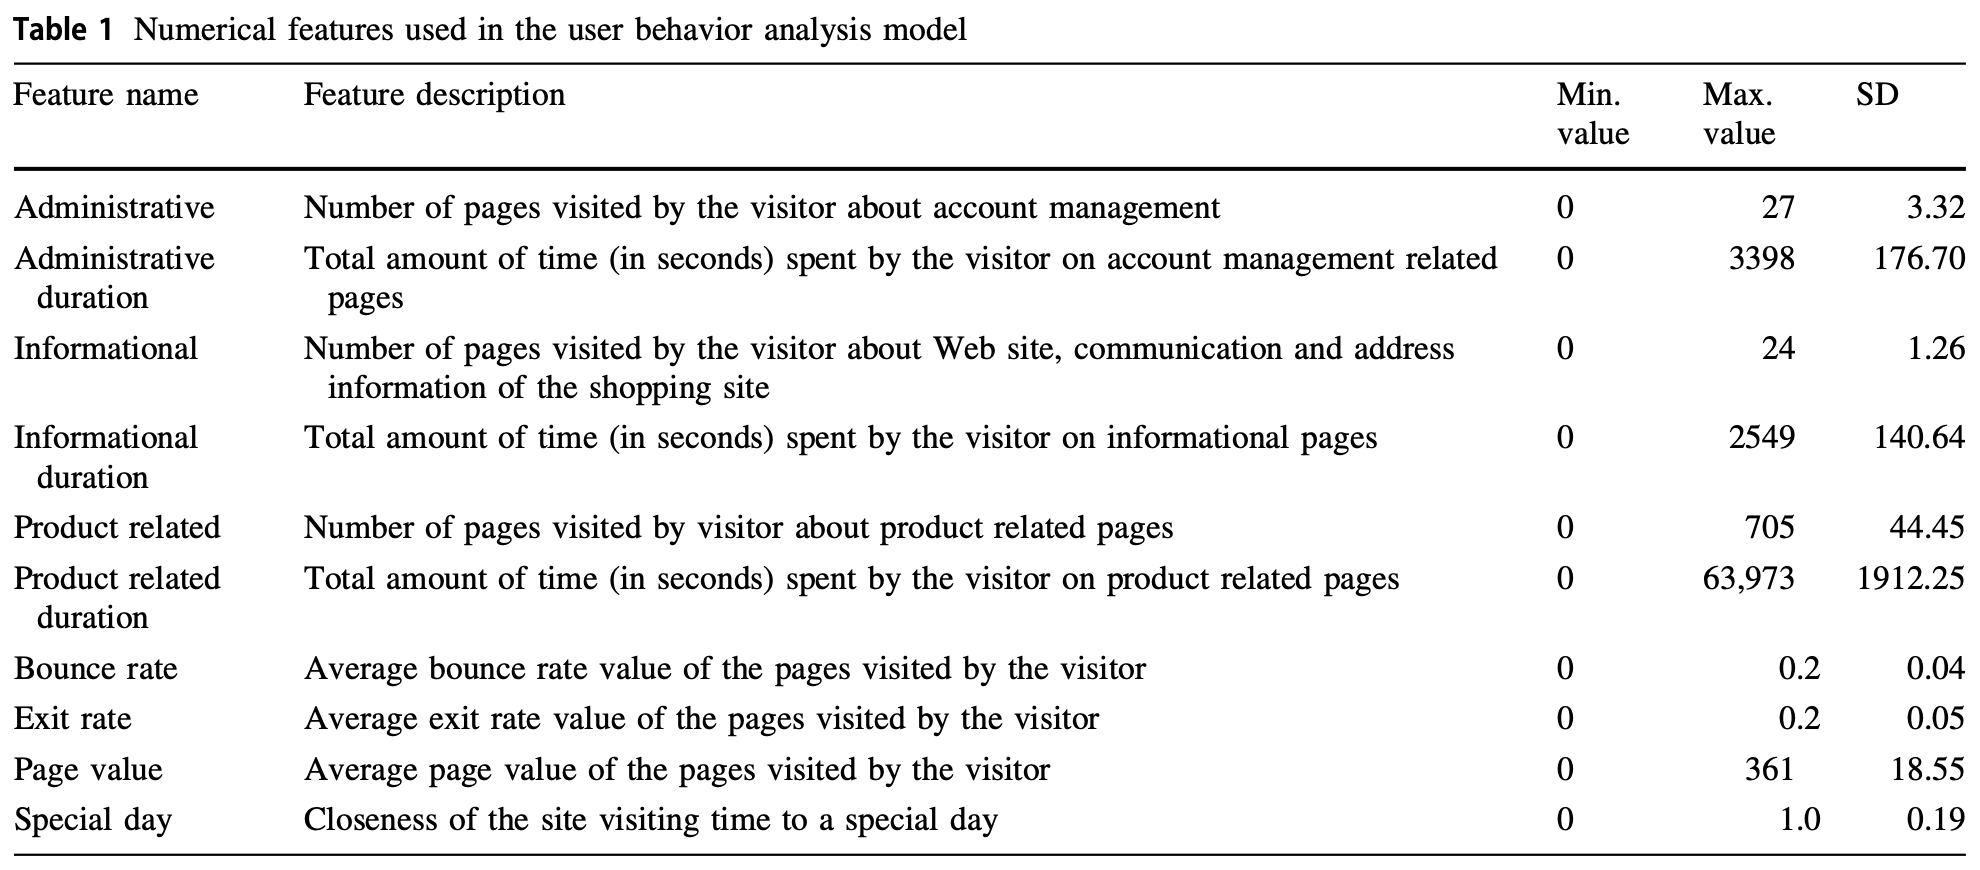



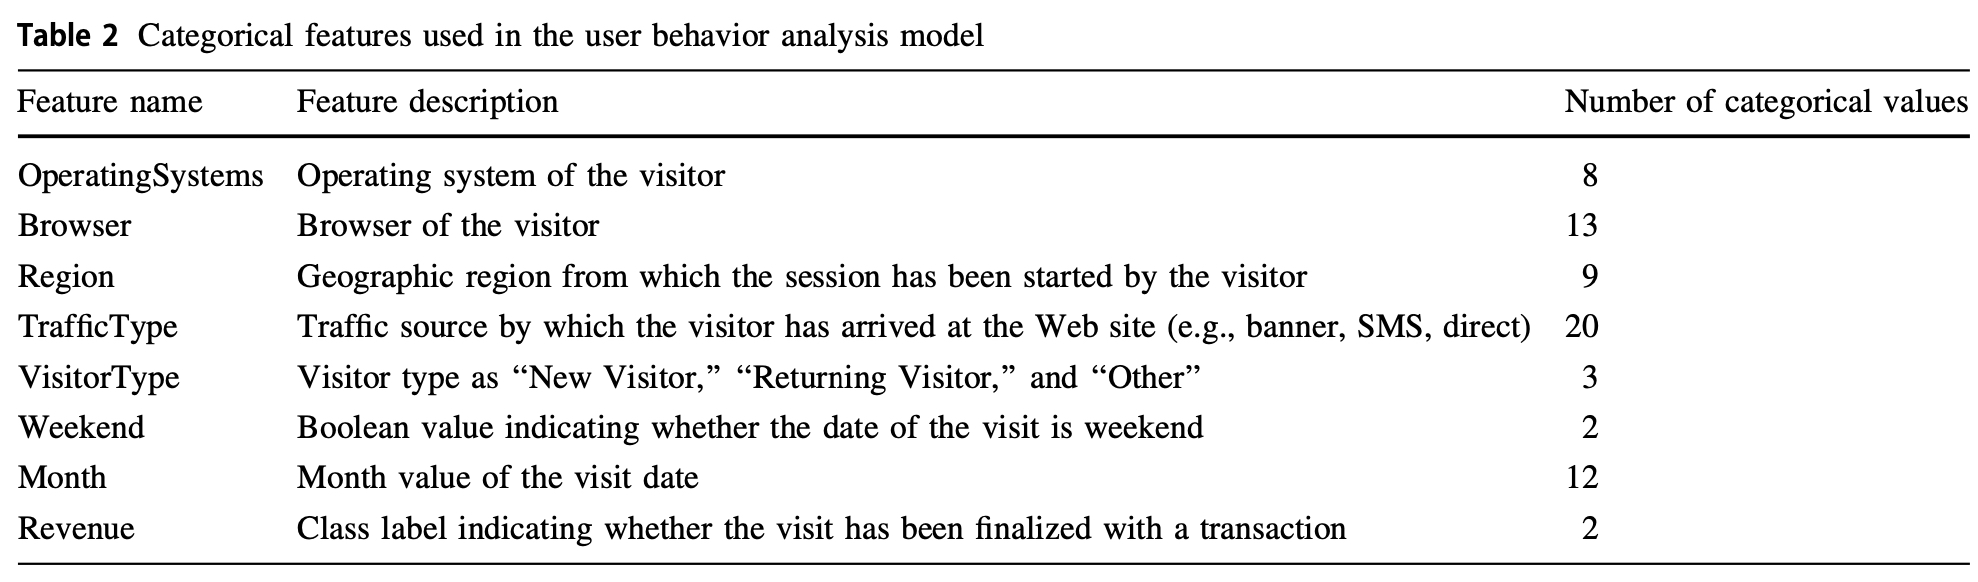